<a href="https://colab.research.google.com/github/labudzki/ComputationalBiology/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sp
import math
import numpy as np

Question 1: Experimental data from an enzyme kinetics experiment is provided in Kinetics.csv file.
The file contains two substrate (S1 and S2) concentrations (in mM) and corresponding rates (in mM/s). (5 points)
1. Identify the underlying enzyme kinetics mechanism
Hint: Use Chi-squared/R-squared measures
2. Make (a) Eadie-Hofstee and (b) Lineweaver-Burk plots for different S2 values of 1.5, 2.5 and 5 mM
3. Extract Michaelis constants (Km1, Km2) and Vmax from the Eadie-Hofstee plot

In [3]:
data = pd.read_csv('Kinetics.csv')
# data

data_filtered = data[data['S2'] <= 1]
data_filtered

# data_filtered = data.iloc[1:,:] #remove first column
# data_filtered = data_filtered[['S1','Rate','S2']].dropna() #remove any NaNs
# data_filtered

s1_data = data_filtered.iloc[:,0]
rate_data = data_filtered.iloc[:,1]
s2_data = data_filtered.iloc[:,2]

# k=1
# s1s2 = k*s1_data * s2_data

# s1s2 = s1s2[100:]
# rate_data = rate_data[100:]

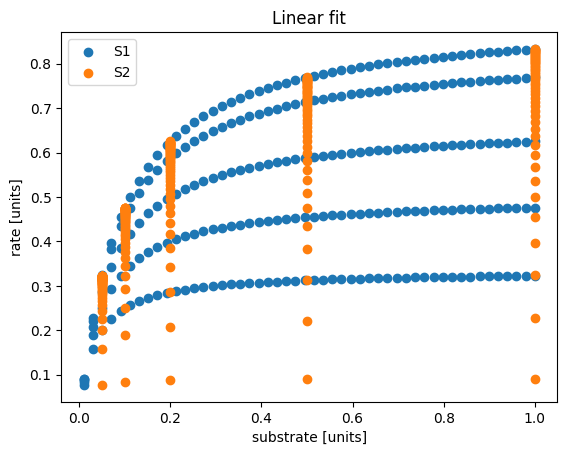

In [4]:
# Fitting a linear function - clearly not a good fit

def linear(x, a, b):
    return a * x + b

# Fit Linear Function
params_linear, _ = sp.curve_fit(linear, s1_data, rate_data)
a_fit, b_fit = params_linear

x_fit = np.linspace(0, 1, 10)

# figure()
# scatter(x, y, label='Data points')  # Use scatter for points
# plot(x_fit, linear(x_fit, *params_linear), color='red', label='Linear Fit')
# legend()
# xlabel('x [units]')
# ylabel('y [units]')
# title('Linear Fit')
# show()

plt.figure()
plt.scatter(s1_data, rate_data, label='S1')
plt.scatter(s2_data, rate_data, label='S2')
# plot(x_fit, linear(x_fit, *params_linear), color='red', label='Linear Fit')
plt.legend()
plt.xlabel('substrate [units]')
plt.ylabel('rate [units]')
plt.title('Linear fit')
plt.show()

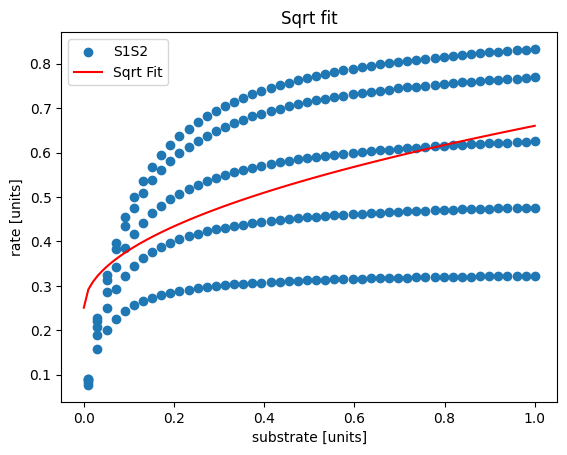

In [5]:
def sqrt_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit Sqrt Function
params_sqrt, _ = sp.curve_fit(sqrt_func, s1_data, rate_data)
a_fit, b_fit, = params_sqrt

x_fit = np.linspace(0, 1, 100)

plt.figure()
plt.scatter(s1_data, rate_data, label='S1S2')
plt.plot(x_fit, sqrt_func(x_fit, *params_sqrt), color='red', label='Sqrt Fit')
plt.legend()
plt.xlabel('substrate [units]')
plt.ylabel('rate [units]')
plt.title('Sqrt fit')
plt.show()

In [22]:
def type_1a(x, y, K1, K2, v_max):
    S1 = x
    S2 = y
    v = (v_max * S1 * S2) / (K2 * K1 + K2 * S1  + S1 * S2)
    return v

def type_1b(x, y, K1, K2, v_max):
    S1 = x
    S2 = y
    v = (v_max * S1 * S2) / (K1 * K2 + K2 * S1 + K1 * S2 + S1 * S2)
    return v

def type_2(x, y, K1, K2, v_max):
    S1 = x
    S2 = y
    v = (v_max * S1 * S2) / (K2 * S1 + K1 * S2 + S1 * S2)
    return v

#%% Goodness of Fit Metrics
def r_squared(y, y_fit):
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)

def chi_squared(y, y_fit):
    return np.sum(((y - y_fit) ** 2) / y_fit)

# Convert the data to numpy arrays
s1_data = data.iloc[:, 0].to_numpy()
s2_data = data.iloc[:, 2].to_numpy()
rate_data = data.iloc[:, 1].to_numpy()

# Stack S1 and S2 into a 2D array
data_input = np.column_stack((s1_data, s2_data))

# # Type 1a
# params_1a, _ = sp.curve_fit(lambda xy, K1, K2, v_max: type_1a(s1_data, s2_data, K1, K2, v_max), data_input, rate_data)
# K1_fit_1a, K2_fit_1a, v_max_fit_1a = params_1a
# print(K1_fit_1a, K2_fit_1a, v_max_fit_1a)

# Type 1b
params_1b, _ = sp.curve_fit(lambda xy, K1, K2, v_max: type_1b(s1_data, s2_data, K1, K2, v_max), data_input, rate_data)
K1_fit, K2_fit, v_max_fit = params_1
print(K1_fit, K2_fit, v_max_fit)

# Type 2
params_2, _ = sp.curve_fit(lambda xy, K1, K2, v_max: type_2(s1_data, s2_data, K1, K2, v_max), data_input, rate_data)
K1_fit_2, K2_fit_2, v_max_fit_2 = params_2

# fitted_data_1a = type_1a(s1_data, s2_data, K1_fit_1a, K2_fit_1a, v_max_fit_1a)
fitted_data = type_1(s1_data, s2_data, K1_fit, K2_fit, v_max_fit)
fitted_data_2 = type_2(s1_data, s2_data, K1_fit, K2_fit, v_max_fit)

# Calculate goodness of fit metrics
# r2_1a = r_squared(rate_data, fitted_data_1a)
# chi2_1a = chi_squared(rate_data, fitted_data_1a)
r2_1 = r_squared(rate_data, fitted_data)
chi2_1 = chi_squared(rate_data, fitted_data)
r2_2 = r_squared(rate_data, fitted_data_2)
chi2_2 = chi_squared(rate_data, fitted_data_2)

# Print the metrics
print(f"Type 1: R-squared: {r2_1}")
print(f"Chi-squared: {chi2_1}")
print(f"Type 2: R-squared: {r2_2}")
print(f"Chi-squared: {chi2_2}")
# print(data_input)


0.08075524027983555 0.08151936837330759 0.9649962588652132
Type 1: R-squared: 0.9950262416141153
Chi-squared: 0.2879791592681083
Type 2: R-squared: 0.9853604249858208
Chi-squared: 0.4448812052133724


Type 1: R-squared: -3.687841860439886
Chi-squared: 63.34133220899183
Type 2: R-squared: -4.360901546542854
Chi-squared: 69.90008464171092

The fit for Type 1 is smaller. this this is type 1 enzyme kinetics.

Make (a) Eadie-Hofstee and (b) Lineweaver-Burk plots for different S2 values of 1.5, 2.5 and
5 mM

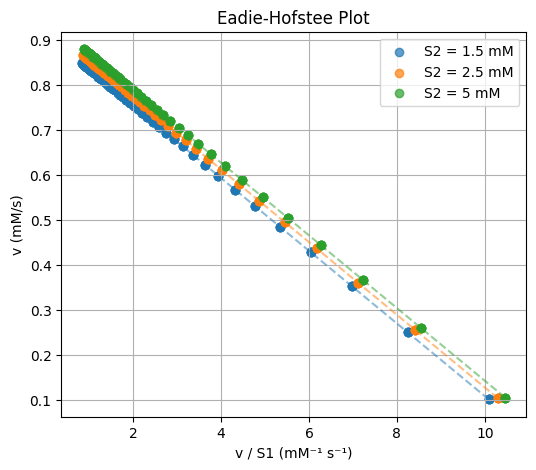

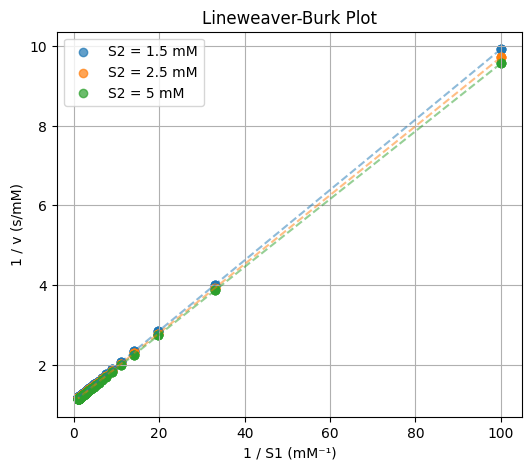

K1: [-0.08 -0.08 -0.08]
v_max: [0.92 0.93 0.95]


In [14]:
def type_1(x, y, K1, K2, v_max):
    S1 = x
    S2 = y
    v = (v_max * S1 * S2) / (K1 * K2 + K2 * S1 + K1 * S2 + S1 * S2)
    return v

s2_vals = [1.5, 2.5, 5] #mM
s1_data = data_filtered.iloc[:,0]

# Store results as a list of tuples (s2, v)
v_values = []

for s2 in s2_vals:
    v = type_1(s1_data, s2, K1_fit, K2_fit, v_max_fit)
    v_values.append((s2, v))  # Store (s2, v) as tuple


# Eadie-Hofstee
# x: v/S
# y: v
# Eadie-Hofstee Plot (v vs. v/S)
# --- Eadie-Hofstee Plot ---
plt.figure(figsize=(6, 5))

K1_vals = []
v_max_vals = []
for s2, v in v_values:
    v_over_s = v / s1_data  # v/S
    plt.scatter(v_over_s, v, label=f"S2 = {s2} mM", alpha=0.7)
    plt.plot(v_over_s, v, linestyle='--', alpha=0.5)  # Optional trendline
    K1 = (v[1]-v[0])/(v_over_s[1]-v_over_s[0])
    # y = mx + b -> b = y - mx
    v_max = v[0] - K1 * v_over_s[0]
    K1_vals.append(K1)
    v_max_vals.append(v_max)

plt.xlabel("v / S1 (mM⁻¹ s⁻¹)")
plt.ylabel("v (mM/s)")
plt.title("Eadie-Hofstee Plot")
plt.legend()
plt.grid(True)
plt.show()

#Lineweaver-burk
# x: 1/s
# y: 1/v
# --- Lineweaver-Burk Plot ---
plt.figure(figsize=(6, 5))

for s2, v in v_values:
    inv_s = 1 / s1_data  # 1/S
    inv_v = 1 / v        # 1/v
    plt.scatter(inv_s, inv_v, label=f"S2 = {s2} mM", alpha=0.7)
    plt.plot(inv_s, inv_v, linestyle='--', alpha=0.5)  #  trendline

plt.xlabel("1 / S1 (mM⁻¹)")
plt.ylabel("1 / v (s/mM)")
plt.title("Lineweaver-Burk Plot")
plt.legend()
plt.grid(True)
plt.show()

print(f"K1: {np.round(K1_vals, 2)}")
print(f"v_max: {np.round(v_max_vals, 2)}")

 Extract Michaelis constants (Km1, Km2) and Vmax from the Eadie-Hofstee plot

In [32]:
#slope of the Eadie-Hofstee plot is the Km1, vm is the y-intercept
# y = mx + b

print(s1_data[0])
print(v_values[0][1][0])




0.01
0.10084878325971891
